1. Convolutional layers with Batch Normalization and Dropout.
2. Attention Mechanism: We'll integrate a basic channel-wise attention mechanism.
3. Advanced layers: Using layers like Separable Convolutions, and GlobalAveragePooling for more efficient feature extraction.

In [1]:
# lib's
import os
import glob

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# Custom Channel-wise Attention Mechanism
class ChannelAttention(layers.Layer):
    def __init__(self, channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.global_max_pool = layers.GlobalMaxPooling2D()
        
        self.fc1 = layers.Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = layers.Dense(channels)
        
    def call(self, inputs):
        avg_pool = self.global_avg_pool(inputs)
        max_pool = self.global_max_pool(inputs)
        
        avg_pool = layers.Reshape((1, 1, self.channels))(avg_pool)
        max_pool = layers.Reshape((1, 1, self.channels))(max_pool)
        
        avg_fc = self.fc2(self.fc1(avg_pool))
        max_fc = self.fc2(self.fc1(max_pool))
        
        attention = layers.Activation('sigmoid')(avg_fc + max_fc)
        
        return inputs * attention

# Custom CNN with Attention
def custom_cnn_with_attention(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Block 1: Convolutional block with Attention
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = ChannelAttention(32)(x)                                                 # Attention applied here
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 2: Advanced Convolutional Block (Separable Conv)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = ChannelAttention(64)(x)                                                 # Attention applied here
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Block 3: Deeper Conv Block with Global Pooling
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = ChannelAttention(128)(x)                                                # Attention applied here
    
    # Global Average Pooling and Fully Connected Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Exanple use
# # Model Compilation and Summary
# input_shape = (128, 128, 3)  # Example input shape
# num_classes = 10  # Example number of output classes

# model = custom_cnn_with_attention(input_shape, num_classes)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [3]:
# Step 1: Define the paths for training and validation data
train_data_dir = os.path.join('..', 'Dataset', 'data', 'train')  # Root folder that contains subfolders '0', '1', '2'
test_data_dir = os.path.join('..', 'Dataset', 'data', 'test')  # Root folder that contains subfolders '0', '1', '2'

# Step 2: ImageDataGenerator for loading and augmenting images
# You can apply real-time augmentation if needed
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    zoom_range = 0.1
)
test_datagen = ImageDataGenerator(rescale = 1./255 )

# Step 3: Load training data (80%) and validation data (20%)
# The flow_from_directory function will infer the labels based on the folder names
train_generator = train_datagen.flow_from_directory(
    directory = train_data_dir,
    target_size = (128, 128),  # Resize all images to the input shape expected by the model
    batch_size = 32,
    class_mode = 'categorical'  # For multi-class classification
)

validation_generator = test_datagen.flow_from_directory(
    directory = test_data_dir,
    target_size = (128, 128),  # Resize all images to the input shape expected by the model
    batch_size = 32,
    class_mode = 'categorical'  # For multi-class classification
)


Found 1206 images belonging to 3 classes.
Found 594 images belonging to 3 classes.


In [4]:
checkpoint_dir = 'checkpoints_CNN_attention_mechanisms_adam'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir,
                                   "model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}_val_loss_{val_loss:.2f}.h5")

checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto')

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0,
                      patience = 10,
                      verbose = 0,
                      mode = 'auto')

reduceLR = ReduceLROnPlateau(monitor="val_loss", 
                             factor=0.1,
                             patience=5, 
                             verbose=0, 
                             mode="auto",
                             min_delta=0.0001, 
                             cooldown=0,
                             min_lr=0.0)

csv_logger = CSVLogger('training.log')

callbacks_list = [checkpoint, reduceLR, csv_logger] #, early

In [6]:
# # Step 4: Create the Custom CNN model with Attention Mechanisms
input_shape = (128, 128, 3)  # Image shape
num_classes = len(glob.glob(os.path.join(train_data_dir, '*'))) # 3
model = custom_cnn_with_attention(input_shape, num_classes)

# Step 5: Compile the model
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Step 6: Train the model
history = model.fit(
    train_generator,  # Training data
    epochs = 100,  # Number of epochs
    validation_data = validation_generator,  # Validation data
    callbacks = callbacks_list
)

# Optional: Save the trained model
save_model_path = os.path.join(checkpoint_dir, 'custom_cnn_attention_model.h5')
model.save(save_model_path)
print(f"Model saved as {save_model_path}.")





Epoch 1/100


38/38 [==============================] - ETA: 0s - loss: 0.8989 - accuracy: 0.5879

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 95s 2s/step - loss: 0.8989 - accuracy: 0.5879 - val_loss: 1.3135 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 79s 2s/step - loss: 0.6620 - accuracy: 0.6841 - val_loss: 2.0327 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/100
38/38 [==============================] - 80s 2s/step - loss: 0.5484 - accuracy: 0.7620 - val_loss: 2.9892 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/100
38/38 [==============================] - 81s 2s/step - loss: 0.4228 - accuracy: 0.8358 - val_loss: 5.0462 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/100
38/38 [==============================] - 81s 2s/step - loss: 0.3732 - accuracy: 0.8483 - val_loss: 7.2406 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/100
38/38 [==============================] - 104s 3s/step - loss: 0.4211 - accuracy: 0.8333 - val_loss: 6.4454 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/100
38/38 [==============================] - 84s 2s/step - loss: 0.3222 - accur

Epoch 53/100
38/38 [==============================] - 76s 2s/step - loss: 0.2636 - accuracy: 0.9013 - val_loss: 0.4626 - val_accuracy: 0.8283 - lr: 1.0000e-06
Epoch 54/100
38/38 [==============================] - 75s 2s/step - loss: 0.2398 - accuracy: 0.9038 - val_loss: 0.4596 - val_accuracy: 0.8300 - lr: 1.0000e-06
Epoch 55/100
38/38 [==============================] - 76s 2s/step - loss: 0.2443 - accuracy: 0.9022 - val_loss: 0.4581 - val_accuracy: 0.8316 - lr: 1.0000e-06
Epoch 56/100
38/38 [==============================] - 75s 2s/step - loss: 0.2620 - accuracy: 0.9055 - val_loss: 0.4577 - val_accuracy: 0.8316 - lr: 1.0000e-06
Epoch 57/100
38/38 [==============================] - 75s 2s/step - loss: 0.2622 - accuracy: 0.9096 - val_loss: 0.4558 - val_accuracy: 0.8300 - lr: 1.0000e-07
Epoch 58/100
38/38 [==============================] - 75s 2s/step - loss: 0.2592 - accuracy: 0.9013 - val_loss: 0.4553 - val_accuracy: 0.8333 - lr: 1.0000e-07
Epoch 59/100
38/38 [==========================

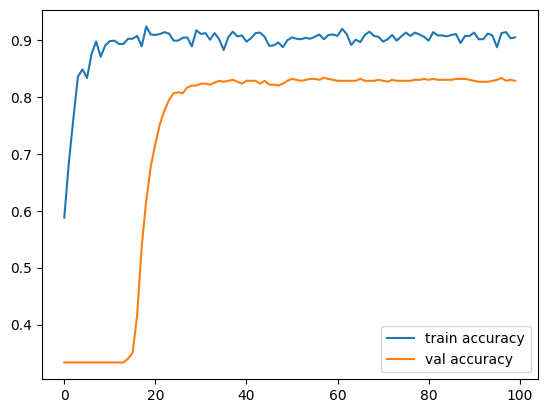

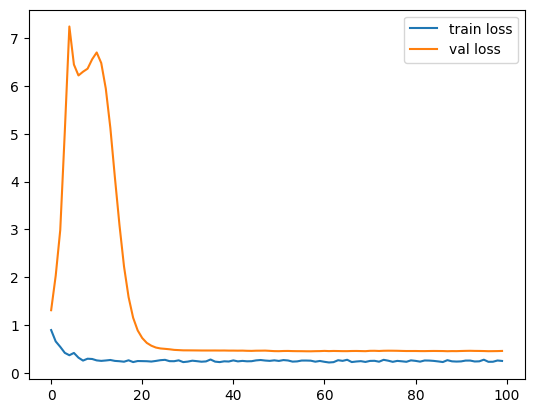

In [7]:
# accuracies
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('CNN_with_attention_mechanisms_adam_model_accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('CNN_with_attention_mechanisms_adam_model_loss_and_val_loss.png', dpi=200)
plt.show()

In [8]:
# Evaluate the model using validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

19/19 [==============================] - 9s 441ms/step - loss: 0.4628 - accuracy: 0.8283
Validation Accuracy: 82.83%


In [9]:
val_data_dir = os.path.join('..', 'Dataset', 'data', 'val')

val_datagen = ImageDataGenerator(rescale = 1./255 )

val_generator = val_datagen.flow_from_directory(
    directory = val_data_dir,
    target_size = (128, 128),  # Resize all images to the input shape expected by the model
    batch_size = 32,
    class_mode = 'categorical'  # For multi-class classification
)

loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Found 4200 images belonging to 3 classes.
132/132 [==============================] - 60s 455ms/step - loss: 0.4865 - accuracy: 0.8160
Validation Accuracy: 81.60%


In [12]:
# score = model.evaluate(train_generator, verbose=0)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

# score = model.evaluate(validation_generator, verbose=0)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

# score = model.evaluate(validation_generator, verbose=0)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

In [11]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

Train loss: 0.46283817291259766
Train accuracy: 0.8282828330993652
